### Thanksgiving 2018

- started fire at 11 am using Minion method
- Placed turkey at 11:40 am
- vents fully open


In [48]:
import numpy,pandas
from collections import OrderedDict
import seaborn
import matplotlib.pyplot as plt

In [100]:
day='11-22-2018'
temptimes = OrderedDict({'11:42':[90,46],
            '11:43':[183,46],
            '11:46':[250,48],
            '11:52':[261,50],
            '12:03':[280,59],
            '12:11':[268,68],
            '12:18':[264,75],
            '12:26':[266,84],
            '12:34':[291,91],
            '12:37':[297,93],
            '12:41':[306,97]})

pdtimes = [pandas.to_datetime('%s %s'%(day,i), dayfirst=True) for i in temptimes]
internal = [temptimes[i][0] for i in temptimes]
air = [temptimes[i][1] for i in temptimes]

bbqdata = pandas.DataFrame({'air':air,'internal':internal},index=pdtimes)
bbqdata['time']=bbqdata.index
bbqdata_tidy = bbqdata.melt(value_vars=['air','internal'],
                            value_name='temperature',var_name='probe',
                           id_vars='time')


### Plot the data

- vertical greem lines show times when I opened the large door to let in more air in order to stoke the fire

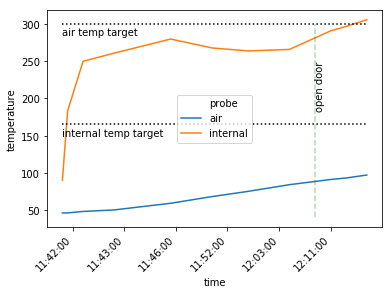

In [101]:
seaborn.lineplot(data=bbqdata_tidy,x='time',
               y='temperature',hue='probe')
plt.plot([bbqdata.time.min(),bbqdata.time.max()],[300,300],'k:')
plt.text(bbqdata.time.min(),285,'air temp target')
plt.text(bbqdata.time.min(),150,'internal temp target')
plt.plot([bbqdata.time.min(),bbqdata.time.max()],[165,165],'k:')
ax=plt.gca()
ax.set_xticklabels([i.time() for i in bbqdata.time], rotation = 45, ha="right")

# add custom stuff
# opened door at 12:31
opentime=[pandas.to_datetime('%s 12:31'%day)]
for o in opentime:
    plt.plot([o,o],[40,300],'g--',alpha=0.3)
    plt.text(o,240,'open door',rotation=90)
    
ventclose = []
ventopen = []

